Notebook to collect the information of the generation

### Import

In [1]:
import sys, os, re
from glob import glob
sys.path.append('../lib')

import time, datetime

In [31]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
for style in plt.style.available:
        plt.style.use(style)
        if style == 'seaborn-bright': 
            break
# plt.style.use('seaborn-bright')
from prettytable import PrettyTable
import humanfriendly
from progressBar import ProgressBar

In [3]:
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

Welcome to JupyROOT 6.12/07


# Inputs

In [4]:
class Bauble: pass

In [5]:
# data_dir = '../data/cmsMC_private/'
# generation_tag = 'BPH_Tag-B0_*pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU35_10-2-3'
# aux = glob(data_dir+generation_tag)
# print aux
# if 'TauNu' in aux[1]:
#     muDir = aux[0]
#     tauDir = aux [1]
# else:
#     muDir = aux[1]
#     tauDir = aux [0]
    
# outDic = {}
# outDic['mu'] = Bauble()
# outDic['mu'].dir = muDir
# outDic['tau'] = Bauble()
# outDic['tau'].dir = tauDir

In [6]:
outDic = {}
# outDic['B2DstTau'] = Bauble()
# outDic['B2DstTau'].dir = '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
outDic['B2DstMu'] = Bauble()
outDic['B2DstMu'].dir = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'

# Efficiency

In [7]:
def getEff(k,N):
    e = k/float(N)
    de = np.sqrt(e*(1-e)/N)
    return [e, de]

In [8]:
for name in outDic.keys():
    print '\n--> ' + name
    master_dir = outDic[name].dir + '/'
    N_gen = {}
    N_gen_cuts = {}
    N_acc = {}
    
    job_dir_list = glob(master_dir + 'jobs_out/out_*[0-9]')
    pb = ProgressBar(maxEntry=len(job_dir_list))
    for i_j, job_dir in enumerate(job_dir_list):
        pb.show(i_j)
        aux = os.path.basename(job_dir)
        n_job = int(aux[4:])
        if not os.path.isfile(job_dir + '/step1.log'): continue
        fname_MINI = master_dir + 'jobs_out/out_MINIAODSIM_{}.root'.format(n_job)
        if not os.path.isfile(fname_MINI): continue
        try:
            f = rt.TFile(fname_MINI, 'READ')
            t = f.Get('Events')
            N_acc[n_job] = int(t.GetEntries())
        except:
            continue

        step1_log_lines = open(job_dir + '/step1.log').readlines()

        for line in reversed(step1_log_lines):
            if 'Pythia::next():' in line:
                break
        N_gen[n_job] = int(line[17:-29])

        for line in reversed(step1_log_lines):
            if 'Begin processing the ' in line:
                break
        aux = re.search(r', Event [0-9]+,', line).group(0)
        N_gen_cuts[n_job] = int(aux[8:-1]) + 49
    
    outDic[name].N_gen = np.array(N_gen.values())
    outDic[name].dic_N_gen = N_gen
    print 'Avg gen:', np.mean(N_gen.values()).astype(np.int)
    
    outDic[name].N_gen_cuts = np.array(N_gen_cuts.values())
    outDic[name].dic_N_gen_cuts = N_gen_cuts
    print 'Avg gen_cuts:', np.mean(N_gen_cuts.values()).astype(np.int)
    
    outDic[name].N_acc = np.array(N_acc.values())
    print 'Avg acc:', np.mean(N_acc.values()).astype(np.int)
    
    cand_out_list = glob(master_dir + 'jo*_B*/out/job*.out')
    N_trg = []
    N_cand = []
    for cand_out in cand_out_list:
        step5_log_lines = open(cand_out).readlines()
        eff_ln = []
        for line in reversed(step5_log_lines):
            if 'efficiency:' in line:
                eff_ln.append(line)

        aux = re.search(': [0-9]+/', eff_ln[1]).group(0)
        N_trg.append(int(aux[2:-1]))

        aux = re.search(': [0-9]+/', eff_ln[0]).group(0)
        N_cand.append(int(aux[2:-1]))
    outDic[name].N_trg = np.array(N_trg)
    print 'Avg N_trg:', np.sum(N_trg) / outDic[name].N_acc.shape[0]
    outDic[name].N_cand = np.array(N_cand)
    print 'Avg N_cand:', np.sum(N_cand) / outDic[name].N_acc.shape[0]


--> B2DstMu
[####################]  100% - Tot. time: 7.1 s
Avg gen: 566600
Avg gen_cuts: 50000
Avg acc: 350
Avg N_trg: 0.0
Avg N_cand: 0.0


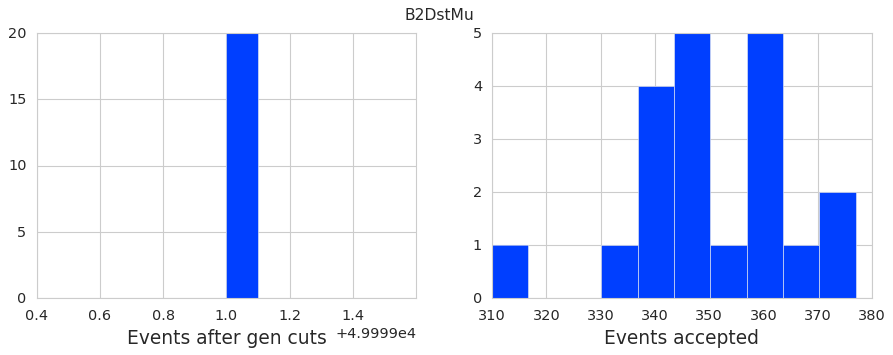

In [33]:
for name, d in outDic.iteritems():
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(name)
    ax[0].hist(d.N_gen_cuts)
    ax[0].set_xlabel('Events after gen cuts')
    ax[1].hist(d.N_acc)
    ax[1].set_xlabel('Events accepted')

    m = mode(d.N_gen_cuts).mode[0]
    for i_j, N_gen_cuts in d.dic_N_gen_cuts.iteritems():
        if m != N_gen_cuts:
            print 'Job',i_j, 'stopped after', N_gen_cuts, 'events'

# Time

In [36]:
for name in outDic.keys():
    print '\n--> ' + name
    master_dir = outDic[name].dir + '/'
    d = outDic[name]
    d.driver_time = []
    d.run_time =[]
    d.tot_time =[]
    
    job_dir_list = glob(master_dir + 'jobs_out/out_*[0-9]')
    pb = ProgressBar(maxEntry=len(job_dir_list))
    for i_j, job_dir in enumerate(job_dir_list):
        pb.show(i_j)
        aux = os.path.basename(job_dir)
        n_job = int(aux[4:])
        
        fn = glob(job_dir + '/out.log'.format(n_job-1))
        if len(fn) == 0:
            continue
        else:
            fn = fn[0]
#         if not os.path.isfile(fn): continue
        test_log_lines = open(fn).readlines()
        
        try:
            crono = [[],[],[],[],[]]
            for i, ln in enumerate(test_log_lines):
                for j in range(1,5):
                    if 'Step '+str(j) in ln or 'Running step '+str(j) in ln:
                        try:
                            crono[j-1].append(float(test_log_lines[i+1][:-1]))
                        except:
                            print '\nError in job', n_job
                            crono[j-1].append(crono[j-1][-1])
            crono[4].append(float(test_log_lines[-1][:-1]))

            driver_time = []
            run_time = []
            for i in range(4):
                driver_time.append(crono[i][1] - crono[i][0])
                run_time.append(crono[i+1][0] - crono[i][1])
            tot_time = crono[4][0] - crono[0][0]

            d.driver_time.append(driver_time)
            d.run_time.append(run_time)
            d.tot_time.append(tot_time)
        except:
            pass
        
    d.driver_time = np.array(d.driver_time)
    d.run_time = np.array(d.run_time)
    d.tot_time = np.array(d.tot_time)


--> B2DstMu
[####################]  100% - Tot. time: 0.0 s


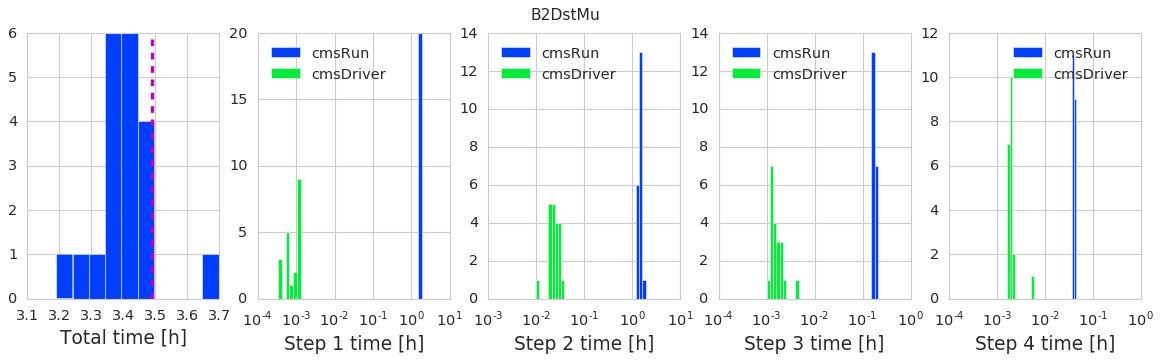

In [56]:
for name, d in outDic.iteritems():
    fig, ax = plt.subplots(1, 5, figsize=(16,4))
    fig.suptitle(name)
    bins = ax[0].hist(d.tot_time/3600, label='cmsRun')
    x = np.percentile(d.tot_time, 90)/3600
    ax[0].plot([x,x], [0,np.max(bins[0])], 'm--', lw=3)
    ax[0].set_xlabel('Total time [h]'.format(i))
    for i in range(1,5):
        m = min(np.min(d.run_time[:,i-1]), np.min(d.driver_time[:,i-1]))/3600
        M = max(np.max(d.run_time[:,i-1]), np.max(d.driver_time[:,i-1]))/3600
        bins = np.logspace(np.log10(0.5*m), np.log10(5*M), 50)
        ax[i].hist(d.run_time[:,i-1]/3600, bins=bins, label='cmsRun')
        ax[i].hist(d.driver_time[:,i-1]/3600, bins=bins, label='cmsDriver')
        ax[i].set_xlabel('Step {} time [h]'.format(i))
        ax[i].legend(loc='best')
        ax[i].set_xscale('log')

# Disk

In [ ]:
for name in outDic.keys():
    print '\n--> ' + name
    master_dir = outDic[name].dir + '/'
    d = outDic[name]
    d.MINIAOD_size = []
    
    job_dir_list = glob(master_dir + 'jobs_out/out_*[0-9]')
    pb = ProgressBar(maxEntry=len(job_dir_list))
    for i_j, job_dir in enumerate(job_dir_list):
        pb.show(i_j)
        aux = os.path.basename(job_dir)
        n_job = int(aux[4:])
        if not os.path.isfile(job_dir + '/step1.log'): continue
        fname_MINI = master_dir + 'jobs_out/out_MINIAODSIM_{}.root'.format(n_job)
        if not os.path.isfile(fname_MINI): continue
        d.MINIAOD_size.append(os.path.getsize(fname_MINI))
    
    d.MINIAOD_size = np.array(d.MINIAOD_size)
    print 'Avg MINIAOD size:', humanfriendly.format_size(np.mean(d.MINIAOD_size), binary=True)

# Print

In [ ]:
for n, d in outDic.iteritems():
    table = PrettyTable()
    table.field_names = ['Step', 'Sub', 'Eff [%]', 'Driver time [s]', 'Running time/evt [s]']
    
    e, de = getEff(np.sum(d.N_acc), np.sum(d.N_gen_cuts))
    dt = np.mean(d.driver_time[:, 0])
    dr_ev = np.mean(d.run_time[:, 0]/d.N_acc)
    table.add_row(['GEN-SIM', '-', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '{:.1f}'.format(dt), '{:.1f}'.format(dr_ev)])
    
    e, de = getEff(np.sum(d.N_gen_cuts), np.sum(d.N_gen))
    table.add_row(['', 'Pythia Gen', 'x {:.1f}'.format(1./e), '-', '-'])
    table.add_row(['', 'Gen Filter', '100.0', '-', '-'])
    e, de = getEff(np.sum(d.N_acc), np.sum(d.N_gen_cuts))
    table.add_row(['', 'CMSSW Filter', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])

    table.add_row(['RAW', '-', '100.0', '{:.1f}'.format(np.mean(d.driver_time[:,1])), '{:.1f}'.format(np.mean(d.run_time[:,1]/d.N_acc))])
    table.add_row(['AOD', '-', '100.0', '{:.1f}'.format(np.mean(d.driver_time[:,2])), '{:.1f}'.format(np.mean(d.run_time[:,2]/d.N_acc))])
    table.add_row(['MINIAOD', '-', '100.0', '{:.1f}'.format(np.mean(d.driver_time[:,3])), '{:.1f}'.format(np.mean(d.run_time[:,3]/d.N_acc))])
    
    e, de = getEff(np.sum(d.N_cand), np.sum(d.N_acc))
    table.add_row(['CAND', '-', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])
    e, de = getEff(np.sum(d.N_trg), np.sum(d.N_acc))
    table.add_row(['', 'BPH Trg', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])
    e, de = getEff(np.sum(d.N_cand), np.sum(d.N_trg))
    table.add_row(['', 'Cand. sel.', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])
    
    table.add_row(len(table.field_names)*[''])
    
    e, de = getEff(np.sum(d.N_cand), np.sum(d.N_gen_cuts))
    table.add_row(['Tot', '', '{:.3f} +/- {:.3f}'.format(100*e, 100*de), '{:.1f}'.format(np.mean(np.sum(d.driver_time, axis=1))), '{:.1f}(*)'.format(np.mean(np.sum(d.run_time, axis=1)/d.N_acc))])

    print n
    print table.get_string()
    
    tabsum = PrettyTable()
    tabsum.field_names = ['Evts req.', '# MINIAOD Evts', '# Cand.', 'Tot. Time [h]']
    
    MINIAOD_size = humanfriendly.format_size(np.mean(d.MINIAOD_size), binary=True)
    tabsum.add_row(['{:.0f}k'.format(1e-3*np.mean(d.N_gen_cuts)), '{:.0f} ({})'.format(np.mean(d.N_acc), MINIAOD_size), '{:.0f}'.format(np.sum(d.N_cand) / d.N_acc.shape[0]), '{:.1f}'.format(np.mean(d.tot_time)/3600.)])
    print tabsum.get_string()
    